# Loading data and importing libraries

In [ ]:
!pip install pyarabic
!pip install networkx
!pip install matplotlib
!pip install arabic-reshaper
!pip install python_bidi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 900.6 kB/s eta 0:00:00


In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,MWETokenizer
from nltk.stem import PorterStemmer
from snowballstemmer import stemmer
import pyarabic.araby as araby
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
from arabic_reshaper import reshape
import string
import re
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
data=pd.read_excel('/content/drive/MyDrive/Complaints dataset.xlsx')

In [ ]:
data

,OFFER_NAME,CUSTOMER_TYPE,COMPLAINT_TYPE,PRODUCT,CASE_LEVEL_1,CASE_LEVEL_2,CASE_LEVEL_3,CUSTOMER_GROUP,CURRENT_STATUS,ESCALATION_FLAG,...,CLOSE_GROUP,AGE_BRACKET,ACTUAL_COMPLAINT,CALLBACK_MECHANISM,RESOLUTION,RESOLUTION_DESCRIPTION,CASE_DESC,OPEN_GR,Unnamed: 22,Unnamed: 23
0,FTTH Home,CBU,Technical,Internet,Technical complaint,TC_INTERNET_CONFIGURATION,SNW-FTTH - WAN configuration / Tools,FTTH Home,Resolved,No,...,NaN,1,User Not Filled,NaN,NaN,NaN,إعادة برمجة من النظامby Sultan,NaN,NaN,NaN
1,NaN,CBU,Technical,Mobile,Technical complaint,TC_INTERNET_CONNEXION,4G - Frequent Disconnection,NaN,Resolved,Yes,...,Mobile_BO,1,Actual Complaint,SMS,Coverage script was sent to the customer,The customer should pay TF + all due amounts i...,عدم التصفح وسوء الخدمه والرجاء اتخاذ قرار ...,System Administrator,NaN,NaN
2,Super 4G on the go 100GB new,CBU,Commercial,Mobile,Commercial claim,CC_Offers,Embedded Bundle - Didn't Get The Monthly Bundles,Family Mobile-IEW,Resolved,Yes,...,Mobile_BO,1,Actual Complaint,SMS,IEW offer -no link,the line is active now & linked & getting the ...,Activation date Sep 22 2022 لم يتم اضافة ا...,NaN,NaN,NaN
3,Pro Bitstream,CBU,Technical,Internet,Technical complaint,TC_Network,SNW-ADSL-Individual fault,Internet SME,Resolved,No,...,NaN,1,User Not Filled,NaN,NaN,NaN,GAIA,NaN,NaN,NaN
4,FTTH Home,CBU,Technical,Internet,Technical complaint,TC_Network,SNW-FTTH - Down interrupted,FTTH Home,Resolved,No,...,NaN,1,User Not Filled,NaN,NaN,NaN,Interrupted,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276287,Pro BEW 1.2 TB,CBU,Technical,Mobile,Technical complaint,TC_Network,4G+ - No Connection Signal,SME Post-Hybrid,Resolved,No,...,NaN,1,User Not Filled,NaN,NaN,NaN,ئئسسسئ,CBU - CC 1st Layer,NaN,NaN
276288,Super IEW 4G 2Y - 500GB - EOY,CBU,Technical,Mobile,Technical complaint,TC_INTERNET_CONNEXION,4G+ - Slow Download,Internet everywhere IEW,Resolved,No,...,NaN,1,User Not Filled,NaN,NaN,NaN,ئئئ,CBU - CC 1st Layer,NaN,NaN
276289,Super 4G on the go 100GB paid,EBU,Technical,Mobile,Technical complaint,TC_Network,4G+ - No Connection Signal,Business Account,Resolved,No,...,NaN,1,User Not Filled,NaN,NaN,NaN,ئئئء,CBU - CC 1st Layer,NaN,NaN
276290,Prepaid residential Basic,CBU,Commercial,Mobile,Commercial claim,CC_Consumption,Usage Bundles - Data,Prepaid,Resolved,No,...,NaN,1,User Not Filled,NaN,NaN,NaN,ئئئئ,CBU - CC 1st Layer,NaN,NaN


In [ ]:
df=data[['CASE_DESC']]

In [ ]:
df

,CASE_DESC
0,إعادة برمجة من النظامby Sultan
1,عدم التصفح وسوء الخدمه والرجاء اتخاذ قرار ...
2,Activation date Sep 22 2022 لم يتم اضافة ا...
3,GAIA
4,Interrupted
...,...
276287,ئئسسسئ
276288,ئئئ
276289,ئئئء
276290,ئئئئ


In [ ]:
df.isnull().sum()

CASE_DESC    0
dtype: int64

In [ ]:
df.duplicated().sum()

134789

In [ ]:
text = df['CASE_DESC'].tolist()

In [ ]:
len(text)

276292

In [ ]:
text

['    إعادة برمجة من النظامby Sultan',
 '    عدم التصفح وسوء الخدمه والرجاء اتخاذ قرار في ذلك سكان الرويشد لواء كامل ولا يوجد لديهم الا برج واحد لشبكة اورنج العالميه اذا لم يتم تصحيح ذلك فاننا نعتذر عن الاستمرار معكم وشكرا.',
 '   Activation date Sep 22 2022  لم يتم اضافة الحزم رقم التواصل: +962789423306',
 '   GAIA',
 '   Interrupted',
 '   Interrupted',
 '   Interrupted',
 '   Never connected ONT  UnknownCONTACT NUMBER 0777151188',
 '   Never connected ONTUnknown07994746460790205560',
 '   Never connected ONTاعادة الاتصال من جانب المودم ',
 '   Never connected ONTالمشترك رافع السرعه  وتم الدخول الى الصفحه اعدادات  الراوتر   لا يقبل الاجراء 0797931041INT0136697',
 '   Never connected ONTالمشترك لا يستطيع الدخول للموقع بشكل نهائي ولا يوجد اي احد للمساعدة بناءا على ذلك تم تسجيل المتابعة يرجى التواصل :0786536971065525677',
 '   Never connected ONTمشكلة برمجية على الموديممسجلة على الtcrm ',
 '   Reduced robustness',
 '   Reduced robustness',
 '   Reduced robustness Minimum: -29.21 dBmMaxi

# Numbers

## Functions

In [ ]:
def separate_numbers_letters(text):
    separated_text = re.findall(r'(\d+|\D+)', text)
    result = ' '.join(separated_text)
    return result

In [ ]:
def find_numbers(text):
    prefixes_to_keep = ['962', '079', '078', '077', '77', '78', '79']
    lengths_to_keep = [9, 10, 12]
    patterns = [rf'\b(?:{prefix})\d{{{length}}}\b' for prefix in prefixes_to_keep for length in lengths_to_keep]
    combined_pattern = '|'.join(patterns)
    return re.findall(combined_pattern, text)

In [ ]:
nested_list = [['962777658989'], ['962777659246'], [], ['962777675700'], ['962777701711'], ['962777702090'], ['962777710762'], [], ['962777732589'], []]
nested_list = [number for sublist in nested_list if sublist for number in sublist]
print(nested_list)

['962777658989', '962777659246', '962777675700', '962777701711', '962777702090', '962777710762', '962777732589']


In [ ]:
#filtered_list = [' '.join([word for word in element.split() if word.isdigit() and word in nested_list or not word.isdigit()])for element in result_list]
#print(filtered_list)

## Removing numbers

In [ ]:
text1=text[0:50000]
text2=text[50000:100000]
text3=text[100000:150000]
text4=text[150000:200000]
text5=text[200000:250000]
text6=text[250000::]

text1

In [ ]:
text1sep = [separate_numbers_letters(text) for text in text1]

In [ ]:
len(text1sep)

50000

In [ ]:
text1all=[find_numbers(text) for text in text1sep]

In [ ]:
len(text1all)

50000

In [ ]:
text1nums=[number for sublist in text1all if sublist for number in sublist]

In [ ]:
len(text1nums)

1719

In [ ]:
text1_list = [' '.join([word for word in element.split() if word.isdigit() and word in text1nums or not word.isdigit()])
    for element in text1sep]

In [ ]:
text1_list

['إعادة برمجة من النظامby Sultan',
 'عدم التصفح وسوء الخدمه والرجاء اتخاذ قرار في ذلك سكان الرويشد لواء كامل ولا يوجد لديهم الا برج واحد لشبكة اورنج العالميه اذا لم يتم تصحيح ذلك فاننا نعتذر عن الاستمرار معكم وشكرا.',
 'Activation date Sep لم يتم اضافة الحزم رقم التواصل: + 962789423306',
 'GAIA',
 'Interrupted',
 'Interrupted',
 'Interrupted',
 'Never connected ONT UnknownCONTACT NUMBER',
 'Never connected ONTUnknown',
 'Never connected ONTاعادة الاتصال من جانب المودم',
 'Never connected ONTالمشترك رافع السرعه وتم الدخول الى الصفحه اعدادات الراوتر لا يقبل الاجراء INT',
 'Never connected ONTالمشترك لا يستطيع الدخول للموقع بشكل نهائي ولا يوجد اي احد للمساعدة بناءا على ذلك تم تسجيل المتابعة يرجى التواصل :',
 'Never connected ONTمشكلة برمجية على الموديممسجلة على الtcrm',
 'Reduced robustness',
 'Reduced robustness',
 'Reduced robustness Minimum: - . dBmMaximum: - . dBmAverage: - . dBmLatest: - . dBm',
 'Switched off',
 'Switched off',
 'Switched off',
 'Switched off',
 'Switched off',
 'Sw

In [ ]:
len(text1_list)

50000

text2

In [ ]:
text2sep = [separate_numbers_letters(text) for text in text2]

In [ ]:
len(text2sep)

50000

In [ ]:
text2all=[find_numbers(text) for text in text2sep]

In [ ]:
len(text2all)

50000

In [ ]:
text2nums=[number for sublist in text2all if sublist for number in sublist]

In [ ]:
len(text2nums)

22

In [ ]:
text2_list = [' '.join([word for word in element.split() if word.isdigit() and word in text2nums or not word.isdigit()])
    for element in text2sep]

In [ ]:
text2_list

['DearsKindly your support to make release & allocate for the below the same customer ( )',
 'DearsKindly your support to make release & allocate for the below the same customer',
 'DearsKindly your support to make release & allocate for the below the same customer safeway th circle',
 'DearsKindly your support to make release & allocate for the below the same customer Safeway th shop',
 'DearsKindly your support to make release & allocate for the below the same customer Safeway th shop',
 'DearsKindly your support to make release & allocate for the below the same customer Safeway th shop',
 'DearsKindly your support to make release & allocate for the below the same customer Safeway th shop',
 'DearsKindly your support to make release & allocate for the below the same customer. Safeway th shop',
 'DearsKindly your support to make release & allocate for the below the same customer Safeway th circle',
 'DearsKindly your support to make release & allocate for the below the same customer',

In [ ]:
len(text2_list)

50000

text3

In [ ]:
text3sep = [separate_numbers_letters(text) for text in text3]

In [ ]:
len(text3sep)

50000

In [ ]:
text3all=[find_numbers(text) for text in text3sep]

In [ ]:
len(text3all)

50000

In [ ]:
text3nums=[number for sublist in text3all if sublist for number in sublist]

In [ ]:
len(text3nums)

383

In [ ]:
text3_list = [' '.join([word for word in element.split() if word.isdigit() and word in text3nums or not word.isdigit()])
    for element in text3sep]

In [ ]:
len(text3_list)

50000

text 4

In [ ]:
text4sep = [separate_numbers_letters(text) for text in text4]

In [ ]:
len(text4sep)

50000

In [ ]:
text4all=[find_numbers(text) for text in text4sep]

In [ ]:
len(text4all)

50000

In [ ]:
text4nums=[number for sublist in text4all if sublist for number in sublist]

In [ ]:
len(text4nums)

1291

In [ ]:
text4_list = [' '.join([word for word in element.split() if word.isdigit() and word in text4nums or not word.isdigit()])
    for element in text4sep]

In [ ]:
len(text4_list)

50000

In [ ]:
text4_list

['the customer has pico please check we sent the case based on the email was sent from Radio teamضعف في التغطيه عطل بجهاز مقوي الشبكه الموقع شفا بدران -بالقرب من مسجد صباح الزين رقم التواصل CAS- -K F M',
 'the customer has picoيعاني المشترك من ضعف في الشبكة في منزله بطابق التسوية ** لدى المشترك اجهزة تقوية للشبكة العنوان : السرو السلط مقابل جامعة عمان الاهلية الاحداثيات : . . Degreesرقم تواصل :',
 'THE CUSTOMER HAS RENEWED HIS LINE THROUGH SOS AND HE CANT MAKE ANY CALL TO AL WATANYA AS ALWAYSYOUR SUPPORT PLEASE',
 'The customer has renewed the subscription on / but receive SMS he use % from dataقمت بتجديد اشتراكي وبعد نصف ساعة من تجديد الاشتراك استلمت رسالة من اورانج لقد استهلكت بالمئة من الحزم الشهرية ولم تظهر لدي الحزم المخصصة لاشتراكي y % A% Aوقمت بمراجعة فرع الزرقاء الجديده ولم استفد شيء% A%',
 'the customer has the LT fees twice.your kind support to compensate the customer',
 'the customer has the mobile line linking with ADSL he wants to CL the ADSL line and link the mobile with 

text 5

In [ ]:
text5sep = [separate_numbers_letters(text) for text in text5]

In [ ]:
len(text5sep)

50000

In [ ]:
text5all=[find_numbers(text) for text in text5sep]

In [ ]:
len(text5all)

50000

In [ ]:
text5nums=[number for sublist in text5all if sublist for number in sublist]

In [ ]:
len(text5nums)

812

In [ ]:
text5_list = [' '.join([word for word in element.split() if word.isdigit() and word in text5nums or not word.isdigit()])
    for element in text5sep]

In [ ]:
len(text5_list)

50000

In [ ]:
text5_list

['النت بطئ وبقطع',
 'النت بطئ وحولت الخط الثابت صار ابطىء ودفعت فرقيه ع أساس نت أسرع بس وعدكم طلع مو صحيح انو السرعه . .',
 'النت بطئ وغلبة بس بدي اشتري حزم نت . .',
 'النت بطئ وما بشبك الموقع: السادسة',
 'النت بطئ ومتقطع رغم انه تم رفع السرعه الى ميجابايت',
 'النت بعلق بطأ انترنت change channel',
 'النت بعيد عنكم بيض وغير هيك بتعطوني خدمه سيئه جدن لو بعرف خدمتكم هيك ما اشتركت معكم وفهمكم زياده',
 'النت بفصل',
 'النت بفصل اكتر من ما بشتغلواذا اشتغل النت بقطع في حل ولا اغير لشبكة تانية صرت متواصل معكم مره',
 'النت بفصل الموقع-شارع الاردن -شارع السفلي-مسجد التوبه رقم الاشتراك رقم التواصل',
 'النت بفصل أكثر ما بشتغل خدمه سيئ',
 'النت بفصل بشكل دائم % Aيوجد عندي اولاد في الجامعه مما يأثر على الامتحانات الرجاء اريد حل لهذه المشكله . .',
 'النت بفصل بشكل دائم % Aيوجد عندي اولاد في الجامعه مما يأثر على الامتحانات الرجاء اريد حل لهذه المشكله . .',
 'النت بفصل طول النهار والليل اعاني من المشكله من شهر',
 'النت بفصل عن الريسيفر',
 'النت بفصل في أوقات متقطعة',
 'النت بفصل في بعض الأوقات',
 'النت 

text 6

In [ ]:
text6sep = [separate_numbers_letters(text) for text in text6]

In [ ]:
len(text6sep)

26292

In [ ]:
text6all=[find_numbers(text) for text in text6sep]

In [ ]:
len(text6all)

26292

In [ ]:
text6nums=[number for sublist in text6all if sublist for number in sublist]

In [ ]:
len(text6nums)

498

In [ ]:
text6_list = [' '.join([word for word in element.split() if word.isdigit() and word in text6nums or not word.isdigit()])
    for element in text6sep]

In [ ]:
len(text6_list)

26292

In [ ]:
text6_list

['عطل جماعي مسجل',
 'عطل جماعي من \\ لا اجراء الي الان',
 'عطل جماعي منطقة طبربور',
 'عطل جماعي وادي السير',
 'عطل جماعي والمشترك له يومين من غير انترنت ومستاء',
 'عطل جماعي والمشتركة منزعجة من التأخر في حل العطل',
 'عطل جماعي والى الان لم يتم حله',
 'عطل جماعي وتم تبليغ العميل',
 'عطل جماعي وتم تبيلغ المشترك',
 'عطل جماعي وفصل الخط الزبون',
 'عطل جماعي وكان قبل متعطل عنده تقريبا أسبوع مشكلة فردية ولم تتصلح .. والزبون معصب كتيييير',
 'عطل جماعي ومسبب خساره ماديه وبده يرفع شكوى بخصوص الخسارة المادية',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',
 'عطل جماعي.',

In [ ]:
text=[]
text.extend(text1_list)
text.extend(text2_list)
text.extend(text3_list)
text.extend(text4_list)
text.extend(text5_list)
text.extend(text6_list)

In [ ]:
len(text)

276292

# Arabic normalization

In [ ]:
text= [araby.strip_tashkeel(t) for t in text]

In [ ]:
def normalize(text):
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ة", "ه", text)
    return text

In [ ]:
text= [normalize(t) for t in text]

In [ ]:
text

['اعاده برمجه من النظامby Sultan',
 'عدم التصفح وسوء الخدمه والرجاء اتخاذ قرار في ذلك سكان الرويشد لواء كامل ولا يوجد لديهم الا برج واحد لشبكه اورنج العالميه اذا لم يتم تصحيح ذلك فاننا نعتذر عن الاستمرار معكم وشكرا.',
 'Activation date Sep لم يتم اضافه الحزم رقم التواصل: + 962789423306',
 'GAIA',
 'Interrupted',
 'Interrupted',
 'Interrupted',
 'Never connected ONT UnknownCONTACT NUMBER',
 'Never connected ONTUnknown',
 'Never connected ONTاعاده الاتصال من جانب المودم',
 'Never connected ONTالمشترك رافع السرعه وتم الدخول الى الصفحه اعدادات الراوتر لا يقبل الاجراء INT',
 'Never connected ONTالمشترك لا يستطيع الدخول للموقع بشكل نهائي ولا يوجد اي احد للمساعده بناءا على ذلك تم تسجيل المتابعه يرجى التواصل :',
 'Never connected ONTمشكله برمجيه على الموديممسجله على الtcrm',
 'Reduced robustness',
 'Reduced robustness',
 'Reduced robustness Minimum: - . dBmMaximum: - . dBmAverage: - . dBmLatest: - . dBm',
 'Switched off',
 'Switched off',
 'Switched off',
 'Switched off',
 'Switched off',
 'Sw

# Preprocessing function

In [ ]:
def remove_symbols(text):
    symbols_to_remove = r'/+-*)\(&%#.,؛:_$^'
    cleaned_text = re.sub('[' + re.escape(symbols_to_remove) + ']', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return cleaned_text

In [ ]:
text= [remove_symbols(doc) for doc in text]

In [ ]:
text

['اعاده برمجه من النظامby Sultan',
 'عدم التصفح وسوء الخدمه والرجاء اتخاذ قرار في ذلك سكان الرويشد لواء كامل ولا يوجد لديهم الا برج واحد لشبكه اورنج العالميه اذا لم يتم تصحيح ذلك فاننا نعتذر عن الاستمرار معكم وشكرا ',
 'Activation date Sep لم يتم اضافه الحزم رقم التواصل    962789423306',
 'GAIA',
 'Interrupted',
 'Interrupted',
 'Interrupted',
 'Never connected ONT UnknownCONTACT NUMBER',
 'Never connected ONTUnknown',
 'Never connected ONTاعاده الاتصال من جانب المودم',
 'Never connected ONTالمشترك رافع السرعه وتم الدخول الى الصفحه اعدادات الراوتر لا يقبل الاجراء INT',
 'Never connected ONTالمشترك لا يستطيع الدخول للموقع بشكل نهائي ولا يوجد اي احد للمساعده بناءا على ذلك تم تسجيل المتابعه يرجى التواصل  ',
 'Never connected ONTمشكله برمجيه على الموديممسجله على الtcrm',
 'Reduced robustness',
 'Reduced robustness',
 'Reduced robustness Minimum      dBmMaximum      dBmAverage      dBmLatest      dBm',
 'Switched off',
 'Switched off',
 'Switched off',
 'Switched off',
 'Switched off',
 'Sw

In [ ]:
def preprocess_text(text):
    # 1. Tokenization
    tokens = nltk.word_tokenize(text)

    # 2. Lowercase conversion
    tokens = [token.lower() for token in tokens]

    # 3. Remove punctuation
    tokens = [token for token in tokens if re.match(r'\w', token)]

    # 4. Remove stopwords
    english_stop_words = set(stopwords.words('english'))
    arabic_stop_words = set(stopwords.words('arabic'))
    tokens = [token for token in tokens if token not in english_stop_words and token not in arabic_stop_words]

    # 5. Stemming
    en_stemmer = PorterStemmer()
    ar_stemmer = stemmer("arabic")
    tokens = [en_stemmer.stem(token) for token in tokens]
    tokens = [ar_stemmer.stemWord(token) for token in tokens]

    # Join tokens back into text
    processed_text = ' '.join(tokens)

    return processed_text

In [ ]:
preprocessed_documents= [preprocess_text(doc) for doc in text]

In [ ]:
preprocessed_documents

['اعاد رمج نظامbi sultan',
 'عدم تصفح سوء خدمه والرجاء اتخاذ قرار سكان رويشد لواء كامل يوجد لدي الا برج لشب اورنج عالميه اذا يتم تصحيح فان نعتذر استمرار معكم شكر',
 'activ date sep يتم اضاف حزم رقم تواصل 962789423306',
 'gaia',
 'interrupt',
 'interrupt',
 'interrupt',
 'never connect ont unknowncontact number',
 'never connect ontunknown',
 'never connect ontاعاد اتصال جانب مودم',
 'never connect ontالمشتر رافع سرعه وتم دخول الي صفحه اعدادا راوتر يقبل اجراء int',
 'never connect ontالمشتر استطيع دخول موقع شكل نهاء يوجد اي احد مساعده ناء تم تسجيل متابعه يرجي تواصل',
 'never connect ontمشكل رمج موديممسجله tcrm',
 'reduc robust',
 'reduc robust',
 'reduc robust minimum dbmmaximum dbmaverag dbmlatest dbm',
 'switch',
 'switch',
 'switch',
 'switch',
 'switch',
 'switch',
 'switch',
 'switch',
 'switch',
 'switch',
 'unknown int upgrad',
 "search queri int n't return result error detect queri simpli result",
 "search queri int n't return result error detect queri simpli result red light ft

In [ ]:
len(preprocessed_documents)

276292

In [ ]:
df['preprocessed']=preprocessed_documents

<ipython-input-88-f11e9986c58d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preprocessed']=preprocessed_documents


In [ ]:
oneword = [word for word in preprocessed_documents if len(word.split()) == 1]
len(oneword)

87225

In [ ]:
unique_df = df[~df['preprocessed'].isin(oneword)]

In [ ]:
unique_df = unique_df.drop_duplicates(subset='preprocessed')

In [ ]:
len(unique_df)

118906

In [ ]:
unique_df=unique_df.reset_index(drop=True)

In [ ]:
unique_df.isnull().sum()

CASE_DESC           0
preprocessed        0
cosine distances    0
dtype: int64

In [ ]:
unique_df.to_excel('uniqueData.xlsx', index=True)

Exception ignored in: <function ZipFile.__del__ at 0x7f32015d9ab0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/zipfile.py", line 1821, in __del__
    self.close()
  File "/usr/lib/python3.10/zipfile.py", line 1838, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


# Query

In [ ]:
unique_df=pd.read_excel('/content/uniqueData.xlsx')

In [ ]:
query=input("Enter your query: ")

Enter your query: internet connection lost


In [ ]:
query1=araby.strip_tashkeel(query)
query1

'internet connection lost'

In [ ]:
query1=normalize(query1)
query1

'internet connection lost'

In [ ]:
query1=remove_symbols(query1)
query1

'internet connection lost'

In [ ]:
query1=preprocess_text(query1)
query1

'internet connect lost'

# TF-IDF

In [ ]:
final_list=unique_df['preprocessed'].tolist()

In [ ]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(final_list)
query_tfidf = vectorizer.transform([query1])

# Cosine similarity

In [ ]:
cosine_similarit= cosine_similarity(tfidf_matrix, query_tfidf)
print("Cosine similarity:")
print(cosine_similarit)

Cosine similarity:
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [ ]:
len(cosine_similarit)

118906

In [ ]:
unique_df['cosine distances']=cosine_similarit

In [ ]:
top_5= unique_df['cosine distances'].nlargest(5)

In [ ]:
top_5

29364    0.702304
1475     0.657231
26308    0.584823
9899     0.537860
16228    0.536361
Name: cosine distances, dtype: float64

In [ ]:
top5_index=top_5.index
top5_values=top_5.values

In [ ]:
top5_index

Int64Index([29364, 1475, 26308, 9899, 16228], dtype='int64')

In [ ]:
unique_df

,CASE_DESC,preprocessed,cosine distances
0,إعادة برمجة من النظامby Sultan,اعاد رمج نظامbi sultan,0.000000
1,عدم التصفح وسوء الخدمه والرجاء اتخاذ قرار ...,عدم تصفح سوء خدمه والرجاء اتخاذ قرار سكان رويش...,0.000000
2,Activation date Sep 22 2022 لم يتم اضافة ا...,activ date sep يتم اضاف حزم رقم تواصل 96278942...,0.000000
3,Never connected ONT UnknownCONTACT NUMBER ...,never connect ont unknowncontact number,0.172422
4,Never connected ONTUnknown07994746460790205560,never connect ontunknown,0.201323
...,...,...,...
118901,يوم السبت تم اخدعا من معرض دار ابو سعيد 899627...,يوم سبت تم اخدع معرض دار ابو سعيد gb,0.000000
118902,يوووجد للزبون خصم بقيمة 50%بالمسجات التي تم دف...,يوووجد للزب خصم قيم مسج تم دفع مبلغ يرجي عمل ا...,0.000000
118903,ييريد تقديم شكووى على مندوب بسبب عند توقيع ال...,ييريد تقديم شكووي مندوب سبب توقيع عقد الزب تم ...,0.000000
118904,ئة البطاقة 12 دينار الإقتطاع: 12545 1754التاري...,يه بطاقه اقتطاع تاريخ وقت مساء اسم بنك بنك عرب...,0.000000


In [ ]:
top5_df=unique_df[['CASE_DESC','preprocessed']].loc[top5_index].copy()

In [ ]:
top5_df

,CASE_DESC,preprocessed
29364,no internet connection,internet connect
1475,"{""description"":""I have lost my internet connec...",descript lost internet connect password pleas ...
26308,lost sim,lost sim
9899,779861834cant connect to internet779861834,cant connect internet
16228,connected without internet,connect without internet


# Graph 1

In [ ]:
Graph1=nx.DiGraph()

In [ ]:
top5_df

,CASE_DESC,preprocessed
29364,no internet connection,internet connect
1475,"{""description"":""I have lost my internet connec...",descript lost internet connect password pleas ...
26308,lost sim,lost sim
9899,779861834cant connect to internet779861834,cant connect internet
16228,connected without internet,connect without internet


In [ ]:
tokenized= [nltk.word_tokenize(doc) for doc in top5_df['preprocessed']]

In [ ]:
tokenized

[['internet', 'connect'],
 ['descript',
  'lost',
  'internet',
  'connect',
  'password',
  'pleas',
  'help',
  'marketplac'],
 ['lost', 'sim'],
 ['cant', 'connect', 'internet'],
 ['connect', 'without', 'internet']]

In [ ]:
merged_tokens = [word for sublist in tokenized for word in sublist]
print(merged_tokens)
set_tokenized=set(merged_tokens)
print(set_tokenized)

['internet', 'connect', 'descript', 'lost', 'internet', 'connect', 'password', 'pleas', 'help', 'marketplac', 'lost', 'sim', 'cant', 'connect', 'internet', 'connect', 'without', 'internet']
{'descript', 'pleas', 'sim', 'connect', 'cant', 'password', 'without', 'internet', 'help', 'lost', 'marketplac'}


In [ ]:
Graph1.add_nodes_from(set_tokenized)

In [ ]:
node_labels = {node: get_display(reshape(node)) for node in Graph1.nodes()}

In [ ]:
edge=[]
for i in tokenized:
  temp=[]
  for j in i:
    temp.append(j)
    if (len(temp)==2):
      edge.append(tuple(temp))
      temp=[]
      temp.append(j)
print(edge)

[('internet', 'connect'), ('descript', 'lost'), ('lost', 'internet'), ('internet', 'connect'), ('connect', 'password'), ('password', 'pleas'), ('pleas', 'help'), ('help', 'marketplac'), ('lost', 'sim'), ('cant', 'connect'), ('connect', 'internet'), ('connect', 'without'), ('without', 'internet')]


In [ ]:
Graph1.add_edges_from(edge)

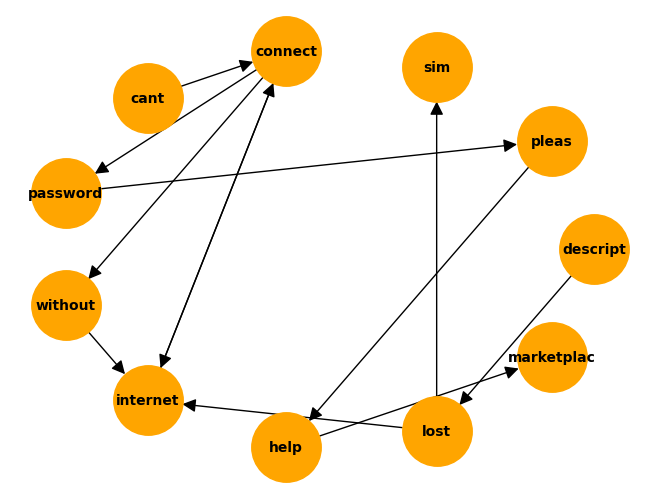

In [ ]:
pos = nx.circular_layout(Graph1)
nx.draw(Graph1, pos,
        with_labels=True,labels=node_labels, arrows=True,
        arrowsize=20,
        node_size=2500,
        node_color='orange',
        font_size=10, font_color='black', font_weight='bold', edge_color='black', linewidths=1)

plt.savefig("Graph.png", format="PNG")
plt.show(block=False)

In [ ]:
degree=nx.degree_centrality(Graph1)
betweenness=nx.betweenness_centrality(Graph1)
closeness=nx.closeness_centrality(Graph1)

# Graph 2

In [ ]:
Graph2= nx.Graph()

In [ ]:
Graph2.add_nodes_from(set_tokenized)

In [ ]:
node_labels = {node: get_display(reshape(node)) for node in Graph2.nodes()}

In [ ]:
tokenized

[['internet', 'connect'],
 ['descript',
  'lost',
  'internet',
  'connect',
  'password',
  'pleas',
  'help',
  'marketplac'],
 ['lost', 'sim'],
 ['cant', 'connect', 'internet'],
 ['connect', 'without', 'internet']]

In [ ]:
combinations=[]
for sublist in tokenized:
    for i in range(len(sublist)):
        for j in range(len(sublist)):
            if i!=j:
              if (sublist[j], sublist[i]) not in combinations:
               combinations.append((sublist[i], sublist[j]))

combinations_dict = {}
for pair in combinations:
    combinations_dict[pair] = combinations_dict.get(pair, 0) + 1
edges = [(pair[0], pair[1], min(count,5)) for pair, count in combinations_dict.items()]
print(edges)

[('internet', 'connect', 4), ('descript', 'lost', 1), ('descript', 'internet', 1), ('descript', 'connect', 1), ('descript', 'password', 1), ('descript', 'pleas', 1), ('descript', 'help', 1), ('descript', 'marketplac', 1), ('lost', 'internet', 1), ('lost', 'connect', 1), ('lost', 'password', 1), ('lost', 'pleas', 1), ('lost', 'help', 1), ('lost', 'marketplac', 1), ('internet', 'password', 1), ('internet', 'pleas', 1), ('internet', 'help', 1), ('internet', 'marketplac', 1), ('connect', 'password', 1), ('connect', 'pleas', 1), ('connect', 'help', 1), ('connect', 'marketplac', 1), ('password', 'pleas', 1), ('password', 'help', 1), ('password', 'marketplac', 1), ('pleas', 'help', 1), ('pleas', 'marketplac', 1), ('help', 'marketplac', 1), ('lost', 'sim', 1), ('cant', 'connect', 1), ('cant', 'internet', 1), ('connect', 'without', 1), ('without', 'internet', 1)]


In [ ]:
Graph2.add_weighted_edges_from(edges)

In [ ]:
edge_weights = nx.get_edge_attributes(Graph2, 'weight')

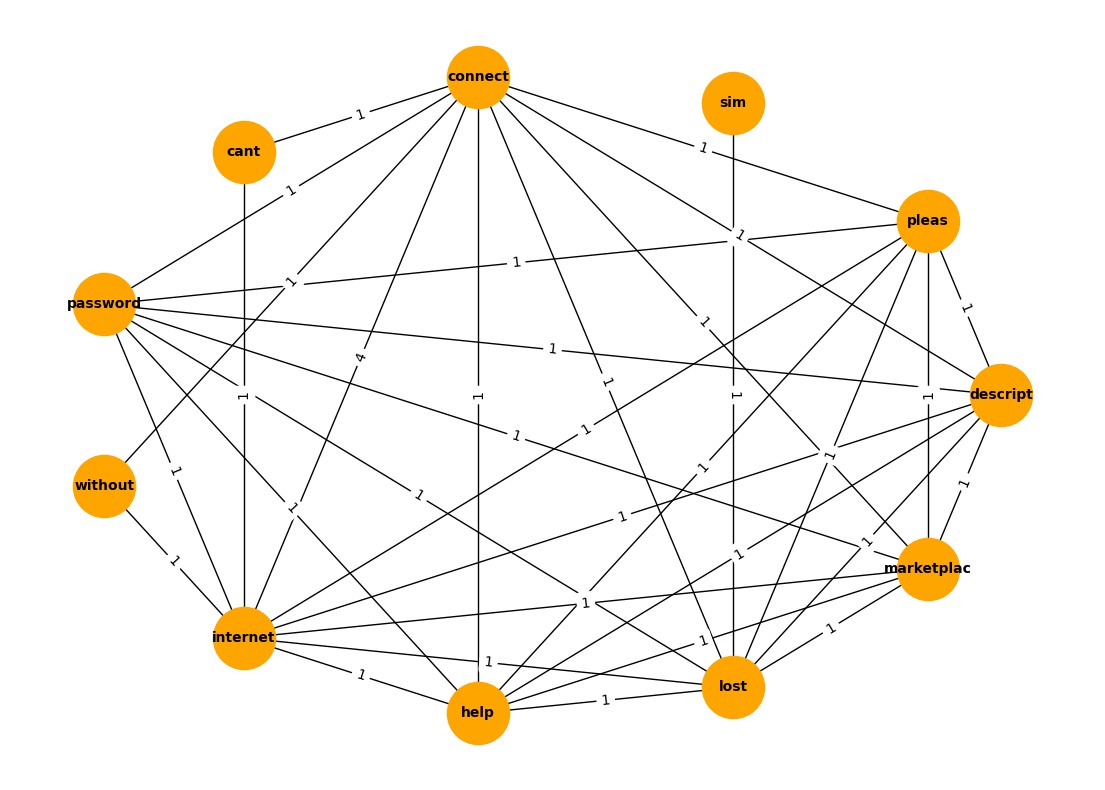

In [ ]:
pos = nx.circular_layout(Graph2)
fig, ax = plt.subplots(figsize=(14,10))

# Draw the network
nx.draw(Graph2, pos, labels=node_labels, with_labels=True, node_size=2000, node_color='orange',
        font_size=10, font_color='black', font_weight='bold', edge_color='black', linewidths=1, arrows=False, ax=ax)

# Draw edge labels
nx.draw_networkx_edge_labels(Graph2, pos, edge_labels=edge_weights)

plt.show()